In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torch.nn.init as init

In [2]:
from torchdiffeq import odeint_adjoint

In [3]:
torch.cuda.empty_cache()

In [4]:
# Encoder & Decoder
class Affine_Coupling(nn.Module):
    def __init__(self, mask, hidden_dim):
        super(Affine_Coupling, self).__init__()
        self.input_dim = len(mask)
        self.hidden_dim = hidden_dim
        # mask to seperate postions that do not change and change
        self.mask = nn.Parameter(mask, requires_grad=False)

        # scale layers hidden_dim=64 maybe
        self.scale_fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.scale_fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.scale_fc3 = nn.Linear(self.hidden_dim, self.input_dim)

        self.scale = nn.Parameter(torch.Tensor(self.input_dim))
        init.normal_(self.scale)

        # translation layers hidden_dim=64 maybe
        self.translation_fc1 = nn.Linear(self.input_dim, self.hidden_dim)
        self.translation_fc2 = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.translation_fc3 = nn.Linear(self.hidden_dim, self.input_dim)

    def _compute_scale(self, x):
        # compute scaling factor using unchanged part of x (s_1, s_2, etc.)
        tanh = nn.Tanh()
        s = self.scale_fc1(x)
        s = tanh(s)
        s = self.scale_fc2(s)
        s = tanh(s)
        s = self.scale_fc3(s)
        s = tanh(s)*self.scale
        return s

    def _compute_translation(self, x):
        # compute translation factor using unchanged part of x (s_1, s_2, etc.)
        t = torch.relu(self.translation_fc1(x))
        t = torch.relu(self.translation_fc2(t))
        t = self.translation_fc3(t)
        return t
    
    # Encoding Block
    def forward(self, x):
        # seperate input vector to x1 x2
        # step one
        x2 = self.mask*x
        x1 = (1-self.mask)*x
        s = self._compute_scale(x2)
        t = self._compute_translation(x2)
        y2 = x2
        y1 = (1-self.mask)*(x1*torch.exp(s)+t)
        x1_out = y1
        # step two
        s1 = self._compute_scale(x1_out)
        t1 = self._compute_translation(x1_out)
        x2_out = self.mask*(y2*torch.exp(s1)+t1)
        # vector combine
        x_out = x1_out + x2_out

        return x_out
    
    # Decoding Block
    def inverse(self, x_out):
        # seperate the vector
        # step one
        x2_out = self.mask*x_out 
        x1_out = (1-self.mask)*x_out
        y1 = x1_out
        s = self._compute_scale(y1)
        t = self._compute_translation(y1)
        y2 = (self.mask)*(x2_out-t)*torch.exp(-s)
        # step two
        x2 = y2
        s1 = self._compute_scale(y2)
        t1 = self._compute_translation(y2)
        x1 = (1-self.mask)*(y1-t1)*torch.exp(-s1)
        # vector combine
        x = x1 + x2

        return x

# Neural ODE Learner
class OdeFunc(nn.Module):
# Structure
    def __init__(self, dim_input, dim_hidden):
        super(OdeFunc, self).__init__()

        self.linear1 = nn.Linear(dim_input, dim_hidden)
        self.relu = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(dim_hidden, dim_hidden)
        self.linear3 = nn.Linear(dim_hidden, dim_input)

# Forward
    def forward(self, t, x):
        # print("x_ode is finite", torch.isfinite(x).all())
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        # print("out is finite", torch.isfinite(out).all())
        return out
    
class OdeSolver(nn.Module):
# Solver
# rtol, atol maybe need proper numbers
    def __init__(self, odefunc, rtol=1e-3, atol=1e-3):
        super(OdeSolver, self).__init__()
        self.odefunc = odefunc
        self.forward_time = torch.tensor([0, 1]).float()
        self.rtol = rtol
        self.atol = atol

    def forward(self, x):
        self.forward_time = self.forward_time.type_as(x)
        out = odeint_adjoint(self.odefunc, x, self.forward_time, rtol=self.rtol, atol=self.atol)

        return out[1]
    
# Neural Information Squeezer
class NIS(nn.Module):
    def __init__(self, mask, hidden_dim, scale):
        # Initialize
        super(NIS, self).__init__()
        # hidden_neurons，这里RealNVP和Ode是共用的，可以再改变
        self.dim = hidden_dim
        # scale for drop some dimension
        self.scale = scale
        # mask: half-half
        self.mask = mask
        # self.batchsize = bs
        # RealNvp
        self.RealNvp1 = Affine_Coupling(self.mask, self.dim)
        self.RealNvp2 = Affine_Coupling(self.mask, self.dim)
        self.RealNvp3 = Affine_Coupling(self.mask, self.dim)
        self.Solver = OdeSolver(OdeFunc(self.mask.shape[0], 64))


    def forward(self, x):
        # Encoding
        y = self.RealNvp1.forward(x)
        y = self.RealNvp2.forward(y)
        y = self.RealNvp3.forward(y)
        # print("yinNIS finite", torch.isfinite(y).all())
        # drop some dimension
        mask_d = torch.cat((torch.zeros(1, len(self.mask)-self.scale), torch.ones(1, self.scale)), -1).to(x.device)
        y = y*mask_d
        # ODESolver

        self.Solver = self.Solver.to(x.device)
        y_out = self.Solver(y)
        # make sure the dimensions are dropped
        y_out = mask_d*y_out
        # add Gaussian Noise
        g_noise = torch.cat((torch.normal(0, 1, size=(1, len(self.mask)-self.scale)),
                             torch.zeros(1, self.scale)), -1).to(x.device)
        y_out = y_out + g_noise
        # Decoding
        x_out = self.RealNvp3.inverse(y_out)
        x_out = self.RealNvp2.inverse(x_out)
        x_out = self.RealNvp1.inverse(x_out)
        
        return x_out, y, y_out

In [5]:
def fit(epochs, model, opt, train_dl):
    num_batches = len(train_dl)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    Loss_Func = nn.MSELoss()
    epoch = 0
    # training
    for epoch in range(epochs):
        batch_count = 0
        print(f"Train epoch{epoch+1}")
        # set model to training mode
        model.train()
        for x, y in train_dl:
            batch_count+=1
            x = x.to(device)
            y = y.to(device)
            # loss calculation
            pred_y,_,_ = model(x.float())
            loss = Loss_Func(pred_y, y.float())
            # backward
            loss.backward()
            opt.step()
            opt.zero_grad()
            if batch_count % int(0.25*num_batches) == 0:
                print('[{}/{}], loss_Norm = {:.4f}'.format(batch_count, num_batches, loss))

            del x, y, pred_y, loss
        epoch += 1

In [6]:
from scipy.integrate import odeint

In [7]:
# Spring Oscillator equation
# dz/dt = v;  dv/dt = −z

def SOE(x, t):
    z1, v1, z2, v2 = x
    dxdt = [v1, -z1, v2, -z2]
    return dxdt


In [8]:
dataset_size = 1280000
x_initial = np.random.uniform(-20, 20, size=[dataset_size, 2])

std1 = np.std(x_initial[:, 0])
std2 = np.std(x_initial[:, 1])
conv = [[std1, 0], [0, std2]]
random = np.random.multivariate_normal([0, 0], conv, size=dataset_size)
# get the micro state of x
random_all = np.concatenate([random, -1*random], 1)
x_all = np.concatenate([x_initial, x_initial], 1)
x_micro = x_all + random_all

t = np.array([0, 1])
solve = np.array([odeint(SOE, x_i, t) for x_i in x_micro])
x_micro1 = solve[:, 1, :]

In [9]:
X_Train, Y_Train =  map(
    torch.from_numpy,
    (x_micro, x_micro1)
)
bs = 128
train_ds = TensorDataset(X_Train, Y_Train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=False)

In [10]:
mask = [0, 0, 1, 1]
mask = torch.tensor(mask)
NIS_SOE = NIS(mask=mask, hidden_dim=64, scale=1)
opt_SOE = optim.Adam(NIS_SOE.parameters(), lr=0.001)

fit(5, model=NIS_SOE, opt=opt_SOE, train_dl=train_dl)

Train epoch1


KeyboardInterrupt: 

In [27]:
valid_dl = DataLoader(train_ds, batch_size=bs, shuffle=False)
all_output = []
all_yv = []
all_y = []
all_y_out = []

for xv, yv in valid_dl:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    NIS_SOE.to(device)
    NIS_SOE.eval()
    xv = xv.to(device)
    yv = yv.to(device)
    output,y,y_out = NIS_SOE(xv.float())
    all_output.append(output.detach().cpu().numpy())
    all_y.append(y.detach().cpu().numpy())
    all_y_out.append(y_out.detach().cpu().numpy())
    all_yv.append(yv.cpu().numpy())

    del xv, yv, output, y, y_out
    torch.cuda.empty_cache()

In [28]:
output_np = np.concatenate(all_output, axis=0)
yv_np = np.concatenate(all_yv, axis=0)
y = np.concatenate(all_y, axis=0)
y_out = np.concatenate(all_y_out, axis=0)

Macro_predict = np.array([(output_np[:, 0]+output_np[:, 2])/2, (output_np[:, 1]+output_np[:, 3])/2])
Macro_actual = np.array([(yv_np[:, 0]+yv_np[:, 2])/2, (yv_np[:, 1]+yv_np[:, 3])/2])

In [29]:
Macro_State = np.concatenate([Macro_actual, Macro_predict], axis=0)

In [12]:
import seaborn as sns

<Axes: >

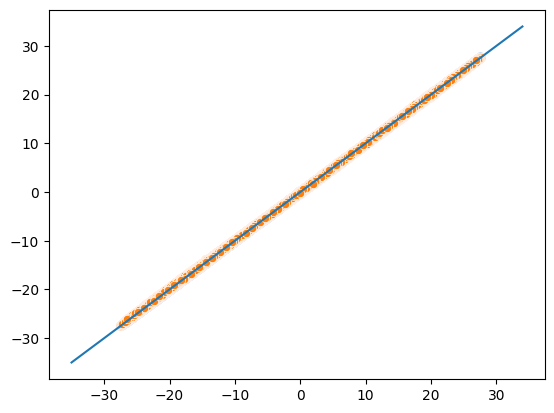

In [30]:
sns.scatterplot(x = Macro_State[0, :], y = Macro_State[2, :])
sns.scatterplot(x = Macro_State[1, :], y = Macro_State[3, :])
sns.lineplot(x = range(-35, 35), y = range(-35, 35))

In [31]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

In [33]:
pearson_position = pearsonr(Macro_State[0, :], Macro_State[2, :])
print(pearson_position)
velocity_position = pearsonr(Macro_State[1, :], Macro_State[3, :])
print(velocity_position)
MSE_position = mean_squared_error(Macro_State[0, :], Macro_State[2, :])
print(MSE_position)
MSE_velocity = mean_squared_error(Macro_State[1, :], Macro_State[3, :])
print(MSE_velocity)

PearsonRResult(statistic=0.9999794903099419, pvalue=0.0)
PearsonRResult(statistic=0.9999596930004258, pvalue=0.0)
0.00614857873660141
0.013408120437956444


<Axes: >

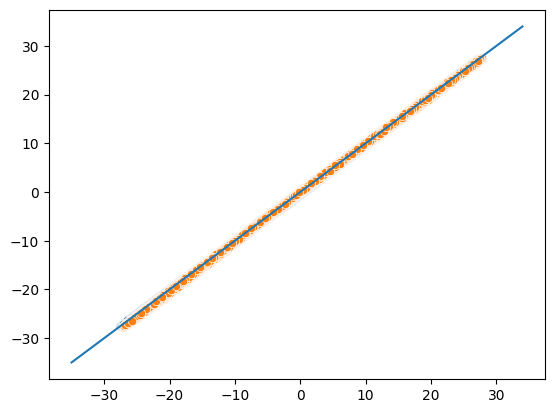

In [32]:
sns.scatterplot(x = y_out[:, 2], y = Macro_actual[0, :])
sns.scatterplot(x = y_out[:, 3], y = Macro_actual[1, :])
sns.lineplot(x = range(-35, 35), y = range(-35, 35))

In [11]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

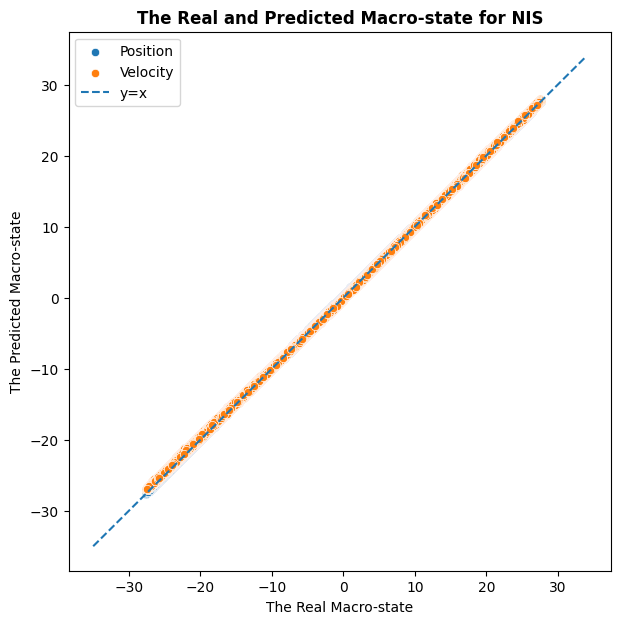

In [39]:
plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0, 0])
ax.set_title('The Real and Predicted Macro-state for NIS', fontweight='bold', fontsize='12')
ax.set_xlabel('The Real Macro-state')
ax.set_ylabel('The Predicted Macro-state')
Macro_plot = sns.scatterplot(x = Macro_actual[0, :], y = y_out[:, 2], legend='full', label='Position')
sns.scatterplot(x = Macro_actual[1, :], y = y_out[:, 3], legend='full', label='Velocity')
sns.lineplot(x = range(-35, 35), y = range(-35, 35), linestyle='--', label='y=x')
plt.legend()

In [41]:
# Macro_plot.get_figure().savefig('Macro_plot.svg')
Macro_plot.get_figure().savefig('Macro_plot.png')

In [42]:
d_position = y_out[:, 2] - y[:, 2]
d_velocity = y_out[:, 3] - y[:, 3]

In [51]:
y2=np.arange(-21, 22)
y2 = -1*y2

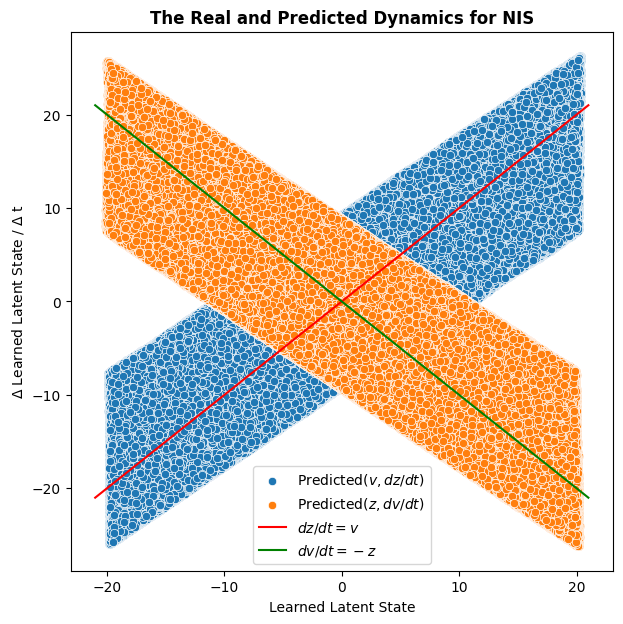

In [52]:
plt.figure(figsize=(7, 7))
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0, 0])
ax.set_title('The Real and Predicted Dynamics for NIS', fontweight='bold', fontsize='12')
ax.set_xlabel('Learned Latent State')
ax.set_ylabel('$\Delta$ Learned Latent State / $\Delta$ t')
Dynamic_plot = sns.scatterplot(x = y[:, 3], y = d_position, legend='full', label='Predicted$(v, dz/dt)$')
sns.scatterplot(x = y[:, 2], y = d_velocity, legend='full', label='Predicted$(z, dv/dt)$')
sns.lineplot(x = range(-21, 22), y = range(-21, 22), linestyle='-', label='$dz/dt=v$', color='red')
sns.lineplot(x = range(-21, 22), y = y2, linestyle='-', label='$dv/dt=-z$', color='green')
plt.legend()

In [54]:
# d_position2=np.copy(0.1*d_position)
# d_velocity2=np.copy(0.1*d_velocity)
# x1 = np.linspace(-21, 22, 20)
# y1 = np.linspace(-2, 2, 20)
# y2 = np.linspace(2, -2, 20)

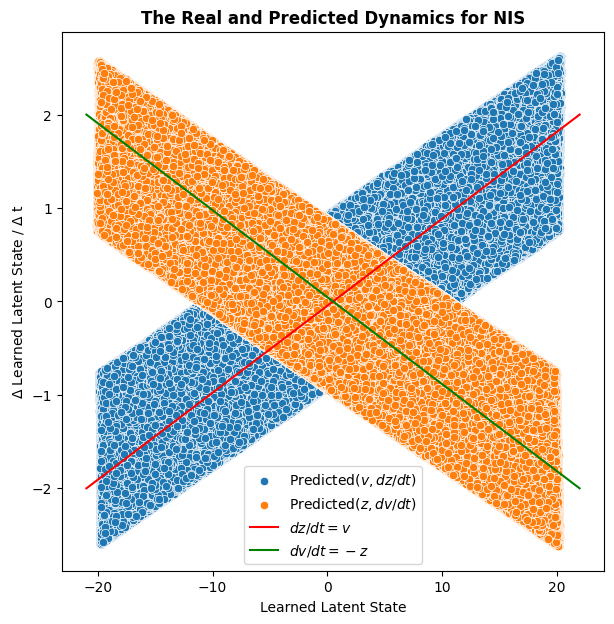

In [55]:
# plt.figure(figsize=(7, 7))
# gs = gridspec.GridSpec(1, 1)
# ax = plt.subplot(gs[0, 0])
# ax.set_title('The Real and Predicted Dynamics for NIS', fontweight='bold', fontsize='12')
# ax.set_xlabel('Learned Latent State')
# ax.set_ylabel('$\Delta$ Learned Latent State / $\Delta$ t')
# Dynamic_plot = sns.scatterplot(x = y[:, 3], y = d_position2, legend='full', label='Predicted$(v, dz/dt)$')
# sns.scatterplot(x = y[:, 2], y = d_velocity2, legend='full', label='Predicted$(z, dv/dt)$')
# sns.lineplot(x = x1, y = y1, linestyle='-', label='$dz/dt=v$', color='red')
# sns.lineplot(x = x1, y = y2, linestyle='-', label='$dv/dt=-z$', color='green')
# plt.legend()

In [53]:
Dynamic_plot.get_figure().savefig('Dynamic_plot.png')

In [22]:
# np.savetxt("predict_MaS.txt", y)
# np.savetxt("predict_MaS_t.txt", y_out)
# np.savetxt("predict_Mis.txt",output_np)
# np.savetxt("actual_Mis.txt", yv_np)
# np.savetxt("actual_Mas.txt", Macro_actual)
# torch.save(NIS_SOE, "NIS_SOE.pth")

In [9]:
import pandas as pd

# df_y = pd.DataFrame(y)
# df_y_out = pd.DataFrame(y_out)
# df_output = pd.DataFrame(output_np)
# df_yv = pd.DataFrame(yv_np)
# df_Macro_actual = pd.DataFrame(Macro_actual)

# df_y.to_excel("predict_MaS.xlsx")
# df_y_out.to_excel("predict_Mas_t.xlsx")
# df_output.to_excel("predict_Mis.xlsx")
# df_yv.to_excel("actual_Mis.xlsx")
# df_Macro_actual.to_excel("actual_Mas.xlsx")

In [57]:
df_micro_initial = pd.DataFrame(x_micro)
df_micro_initial.to_csv("micro_initial.csv")

In [7]:
initial_state=np.array([3.82961751,3.295378202,-6.884415995,-9.251218459])
t = np.linspace(0, 100, 100)
actual_state_100 = odeint(SOE, initial_state, t)
# df_actual_state_100 = pd.DataFrame(actual_state_100)
# df_actual_state_100.to_csv("actual_state_100.csv")

In [63]:
Macro_actual_100 = np.array([(actual_state_100[:, 0]+actual_state_100[:,2])/2, (actual_state_100[:, 1]+actual_state_100[:,3])/2])

<Axes: >

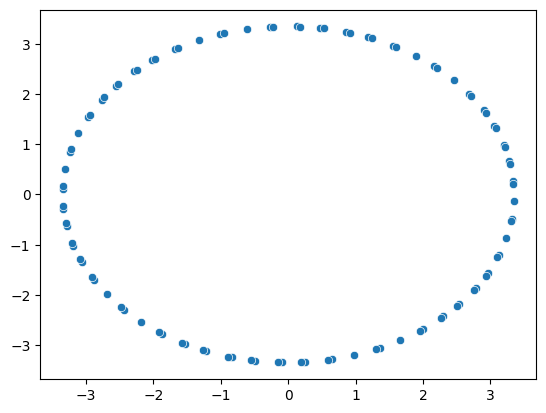

In [65]:
sns.scatterplot(x=Macro_actual_100[0, :], y=Macro_actual_100[1, :])

<Axes: >

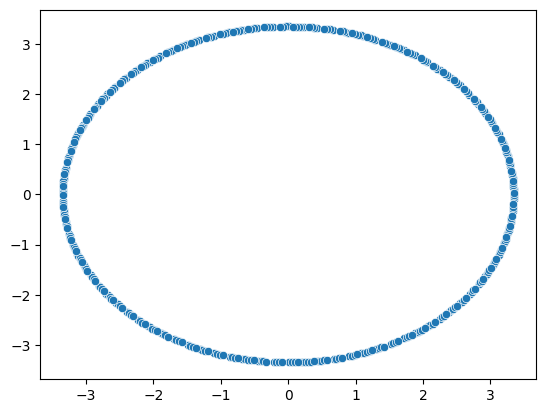

In [13]:
initial_state=np.array([3.82961751,3.295378202,-6.884415995,-9.251218459])
t = np.linspace(0, 401, 401)
actual_state_400 = odeint(SOE, initial_state, t)
df_actual_state_400 = pd.DataFrame(actual_state_400)
actual_state_400 = actual_state_400[1: 401, :]
# df_actual_state_400.to_csv("actual_state_400.csv")
Macro_actual_400 = np.array([(actual_state_400[:, 0]+actual_state_400[:,2])/2, (actual_state_400[:, 1]+actual_state_400[:,3])/2])
sns.scatterplot(x=Macro_actual_400[0, :], y=Macro_actual_400[1, :])

In [15]:
# NIS_SOE = torch.load('NIS_SOE.pth')
# # torch.load('NIS_SOE.pth')

In [17]:
x = initial_state
x = torch.tensor(x)
x_out_list = []
y_out_list = []
for i in range(400):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    x = x.to(device)
    x_out,_,y_out = NIS_SOE(x.float())
    x = x_out

    x_out_list.append(x_out.detach().cpu().numpy())
    y_out_list.append(y_out.detach().cpu().numpy())

    del x_out, y_out

In [18]:
x_out_np = np.concatenate(x_out_list, axis=0)
y_out_np = np.concatenate(y_out_list, axis=0)
predict_100 = np.array([(x_out_np[:, 0]+x_out_np[:, 2])/2, (x_out_np[:, 1]+x_out_np[:, 3])/2])

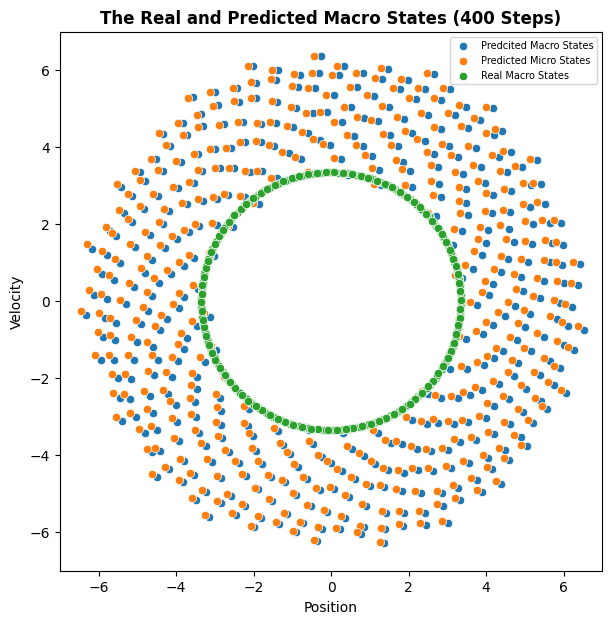

In [20]:
plt.figure(figsize=[7, 7])
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0,0])
ax.set_title('The Real and Predicted Macro States (400 Steps)', fontweight='bold', fontsize='12')
ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
plt.xlim(-7, 7)
plt.ylim(-7, 7)
Macro_states_Multi_Steps = sns.scatterplot(x=y_out_np[:, 2], y=y_out_np[:, 3], legend='full', label= 'Predcited Macro States')
sns.scatterplot(x=predict_100[0, :], y=predict_100[1, :], legend='full', label= 'Predicted Micro States')
sns.scatterplot(x=Macro_actual_400[0, :], y=Macro_actual_400[1, :], legend='full', label='Real Macro States')
plt.legend(loc='upper right', prop={'size': 7})

In [21]:
# Macro_states_Multi_Steps.get_figure().savefig('400steps.svg')
Macro_states_Multi_Steps.get_figure().savefig('Real_NVP_400steps.png')

In [23]:
import imageio
import os


gif_filename = 'Real_NVP_400_steps.gif'

# 用于存储帧的列表
frames = []

# 动图的帧数
num_frames = 400

# 创建图形对象
for i in range(1, num_frames + 1):
    fig = plt.figure(figsize=[7, 7])
    gs = gridspec.GridSpec(1, 1)
    ax = plt.subplot(gs[0, 0])
    ax.set_title('The Real and Predicted Macro States (400 Steps)', fontweight='bold', fontsize='12')
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    plt.xlim(-7, 7)
    plt.ylim(-7, 7)

    # 绘制当前帧的散点图
    sns.scatterplot(x=y_out_np[:i, 2], y=y_out_np[:i, 3], legend='full', label='Predicted Macro States', ax=ax)
    sns.scatterplot(x=predict_100[0, :i], y=predict_100[1, :i], legend='full', label='Predicted Micro States', ax=ax)
    sns.scatterplot(x=Macro_actual_400[0, :i], y=Macro_actual_400[1, :i], legend='full', label='Real Macro States', ax=ax)
    plt.legend(loc='upper right', prop={'size': 7})
    # 存储当前帧
    temp_filename = f'temp_frame_{i}.png'
    plt.savefig(temp_filename)
    frames.append(imageio.imread(temp_filename))
    plt.close()

# 创建 GIF 动画
imageio.mimsave(gif_filename, frames, fps=10)

# 删除临时文件
for temp_filename in [f'temp_frame_{i}.png' for i in range(1, num_frames + 1)]:
    os.remove(temp_filename)

C:\Users\15170\AppData\Local\Temp\ipykernel_40376\1834889149.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(temp_filename))
C:\Users\15170\AppData\Local\Temp\ipykernel_40376\1834889149.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frames.append(imageio.imread(temp_filename))
C:\Users\15170\AppData\Local\Temp\ipykernel_40376\1834889149.py:32: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as im